## Comparison between State-of-the-Art Architecture and Conventional One on Semantic Segmentation Task

### Background and Aim

- 今までセグメンテーションタスクにおいては自分の理解できる範囲のアーキテクチャを使っていた
- 最新のアーキテクチャとの比較を行いたい
- 比較するデータはコンペに使うようなものよりなるべく実用に近いものが良いと考え医療データで行いたい
- 比較方法は損失関数による定量的な比較と、主観的な実際の処理されたセグメンテーション画像の印象で行う

### State-of-the-Art Architectrue: Deep Lab V3 Plus

- Atrous ConvolutionによってGlobalなContextを考慮できる（受容野が広い）
- Dilation Rateは調節可能（Local/Global のどちらの特徴量を重視するか）
- DLV3に比べて誤差の伝搬経路をスキップできる
- Full-Resolution Residual Networks　などに比べかなり軽量

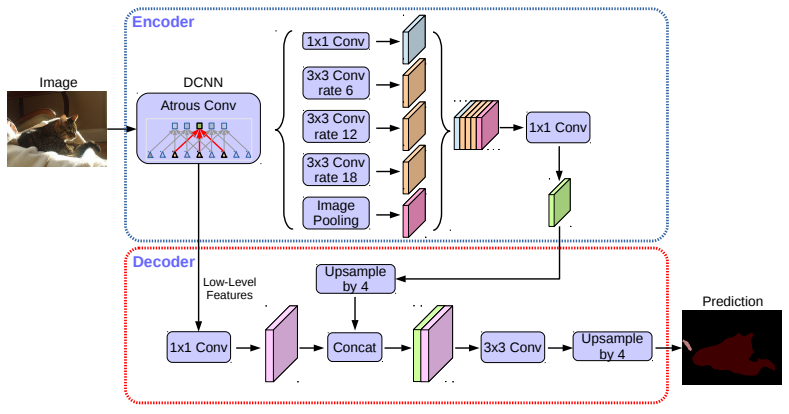

In [65]:
import sys
sys.path.append('/home/yoshiki_watanabe/Desktop/project/util')
print(sys.path)

from __future__ import print_function
%load_ext autoreload
%autoreload 2
import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
import glob
from PIL import Image
from pylab import rcParams

from keras.models import Model
import keras


import pickle
from tqdm import tqdm

import cv2



from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, ZeroPadding2D, LeakyReLU, BatchNormalization,Activation, Dropout
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.layers import Input, Cropping2D
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

from network_unet import get_unet_deep1
from network_unet import get_unet_simple
from network_unet import UNet

from network_unet import dice_coef
from network_unet import dice_coef_loss
from model_DLV3P import Deeplabv3

# from callbacks import generate_arrays_from_file
import callbacks


['', '/usr/local/DL-Box/digits-5.0/caffe/python', '/usr/local/pyenv/versions/anaconda3-5.2.0/lib/python36.zip', '/usr/local/pyenv/versions/anaconda3-5.2.0/lib/python3.6', '/usr/local/pyenv/versions/anaconda3-5.2.0/lib/python3.6/lib-dynload', '/usr/local/pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages', '/usr/local/pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/IPython/extensions', '/home/yoshiki_watanabe/.ipython', '/home/yoshiki_watanabe/Desktop/project/util', '/home/yoshiki_watanabe/Desktop/project/util', '/home/yoshiki_watanabe/Desktop/project/util', '/home/yoshiki_watanabe/Desktop/project/util']
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto(
    gpu_options=tf.GPUOptions(
        visible_device_list="1", # specify GPU number
        allow_growth=False
    )
)
set_session(tf.Session(config=config))

In [67]:

np.random.seed(0)
tf.set_random_seed(0)


In [68]:
# Data save path
path_data_save = '../result/try5_1_alldata_DLV3P/'

data_name = 'unet'
model_num = 8 # 1:get_unet_single, 2:get_unet_deep1, 3: UNet 4: unet_360x640_shallow1 5: unet_720x1280

path_weight_load = path_data_save+'weights_DLV3P.h5'
# Teacher Data Path
path_data_y = "../data/data_all_separate/val/label/*"
path_data_x = "../data/data_all_separate/val/movieFrame/*"

# Segmentation Index Settings
use_label = 1 # All number of segmentation object
idx_start = 204 # This case I use the index from 240~255

# Network settings
output_labels = use_label
base_f_cnt = 32

label_axis = ['nerve']



In [87]:
files_y = sorted(glob.glob(path_data_y))
files_x = sorted(glob.glob(path_data_x))
y_pre = []
x = []


for f in tqdm(files_y[:450]):
    im = Image.open(f)
    y_pre.append(np.array(im))

y_pre = (np.asarray(y_pre)).astype('float32')

for f in tqdm(files_x[:450]):
    im = Image.open(f)
    x.append(np.array(im))
    
x = (np.asarray(x)).astype('float32')



100%|██████████| 81/81 [00:00<00:00, 124.27it/s]


In [88]:
x_mean = np.mean(x)
x_std = np.std(x)
x -= x_mean
x /= x_std
x /= 255

In [89]:
print(x_mean)
print(x_std)

97.58124
71.72156


In [90]:
# Definition of y as masks of all objects
y_dim = (y_pre.shape[0], y_pre.shape[1], y_pre.shape[2], use_label)
y = np.zeros(y_dim, dtype='bool')
for label in tqdm(range(use_label)):
    idx = np.where(y_pre==(idx_start+label))
    if len(idx[0]) <= 0: # 一つも要素が見つからないときidx[0], idx[1], idx[2]がすべて0になる
        print('label '+str(label)+'skipped')
        
    y[idx[0],idx[1],idx[2],label] = True

100%|██████████| 1/1 [00:00<00:00, 16.36it/s]


In [91]:
[ _, img_rows, img_cols, img_channels] = x.shape # Ignore sample size

In [92]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, test_size=0.2)

x_test = x
y_test = y


In [93]:
if model_num==1:
    model = get_unet_single()
elif model_num==2:
    model = get_unet_deep1(img_rows, img_cols)
elif model_num==3:
    unet = UNet(input_shape=(img_rows, img_cols, img_channels), output_ch=output_labels, base_filter_cnt=base_f_cnt)
    model = unet.unet_360x640()
    model.compile(loss=dice_coef_loss, optimizer=Adam(), metrics=[dice_coef])
elif model_num==4:
    unet = UNet(input_shape=(img_rows, img_cols, img_channels), output_ch=output_labels, base_filter_cnt=base_f_cnt)
    model = unet.unet_360x640_shallow1()
    model.compile(loss=dice_coef_loss, optimizer=Adam(), metrics=[dice_coef])
elif model_num==5:
    unet = UNet(input_shape=(img_rows, img_cols, img_channels), output_ch=output_labels, base_filter_cnt=base_f_cnt)
    model = unet.unet_720x1280_2()
    model.compile(loss=dice_coef_loss, optimizer=Adam(lr=0.01), metrics=[dice_coef])
elif model_num==6:
    unet = UNet(input_shape=(img_rows, img_cols, img_channels), output_ch=output_labels, base_filter_cnt=base_f_cnt)
    model = unet.unet_360x640_2()
    model.compile(loss=dice_coef_loss, optimizer=Adam(lr=0.01), metrics=[dice_coef])
    print('unet_360x640_2')
elif model_num==7:
    unet = UNet(input_shape=(img_rows, img_cols, img_channels), output_ch=output_labels, base_filter_cnt=base_f_cnt)
    model = unet.unet_360x640_2()
    model.compile(loss=dice_coef_loss, optimizer=SGD(lr=0.005, momentum = 0.9), metrics=[dice_coef])
    print('unet_360x640_2, SGD')
    
elif model_num == 8:
    model = Deeplabv3(input_shape=(img_rows,img_cols,img_channels), classes=1)  
    model.compile(loss=dice_coef_loss, optimizer=SGD(lr=0.02, momentum = 0.9), metrics=[dice_coef])
    print('Deeplabv3, SGD')


model_checkpoint = ModelCheckpoint(path_data_save+'weights_'+data_name+'.h5', monitor='val_loss', save_best_only=True)
if path_weight_load!="":
    model.load_weights(path_weight_load)
    print('Model Weight was loaded.')

Deeplabv3, SGD
Model Weight was loaded.


In [94]:
unet = UNet(input_shape=(img_rows, img_cols, img_channels), output_ch=output_labels, base_filter_cnt=base_f_cnt)
model2 = unet.unet_360x640_2()
model2.compile(loss=dice_coef_loss, optimizer=Adam(lr=0.01), metrics=[dice_coef])
model2.load_weights('../result/try6_2_alldata_additional_1_comparison_conventional/'+'weights_unet.h5')

/home/yoshiki_watanabe/Desktop/project/nerve/code/network_unet.py:170: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`
  return Model(input=inputs, output=outputs)


Data: 0
Ground Truth


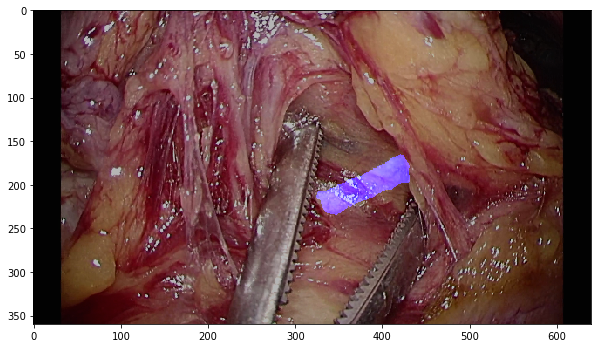



Predicted by DLV3P


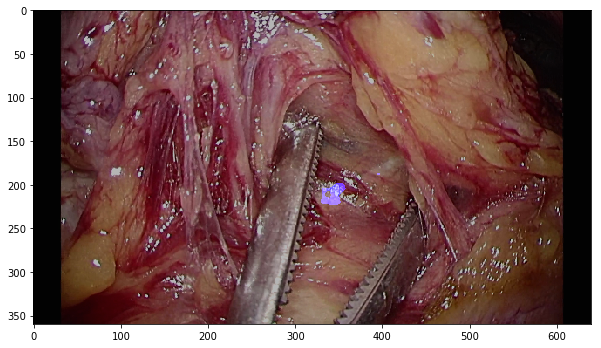



Predicted by Conventional Unet Structure


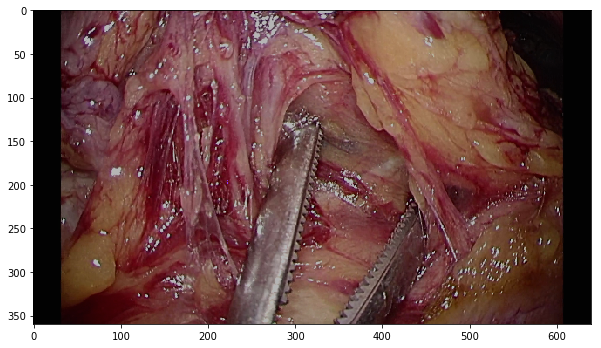

Data: 15
Ground Truth


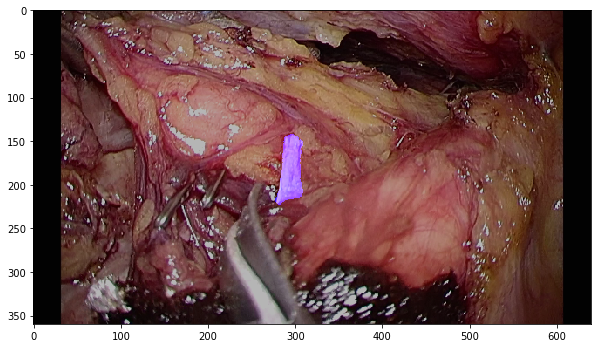



Predicted by DLV3P


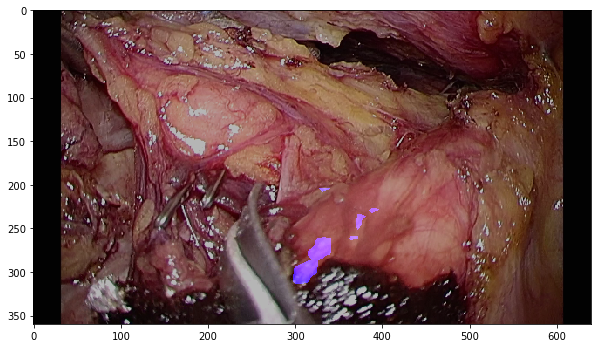



Predicted by Conventional Unet Structure


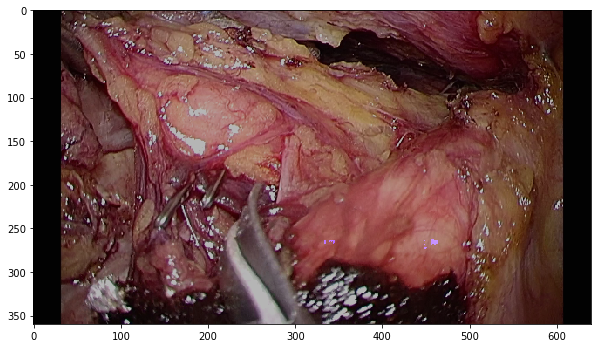

Data: 30
Ground Truth


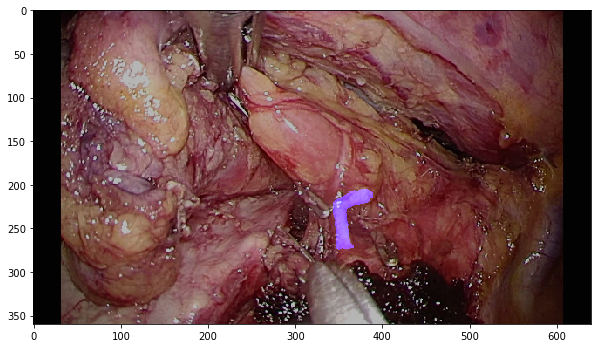



Predicted by DLV3P


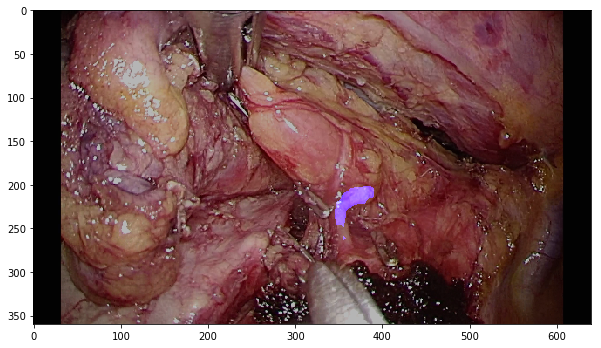



Predicted by Conventional Unet Structure


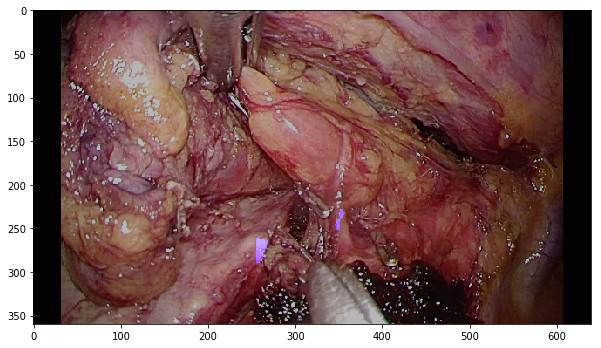

Data: 45
Ground Truth


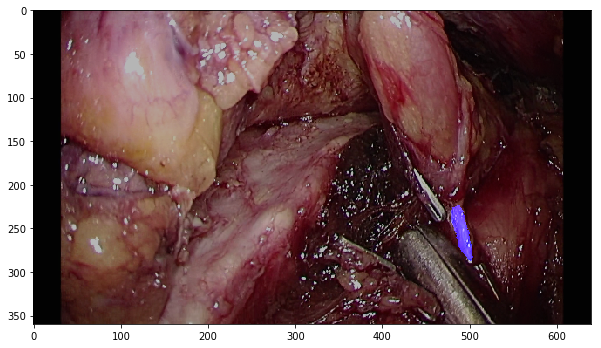



Predicted by DLV3P


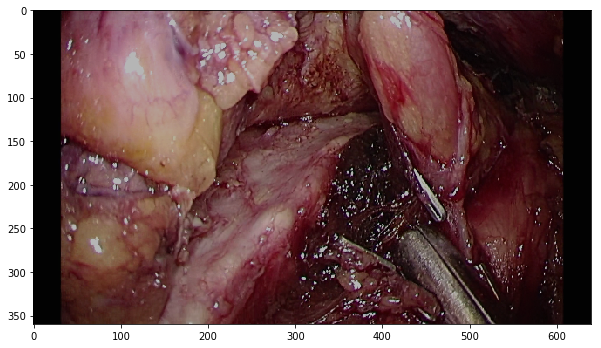



Predicted by Conventional Unet Structure


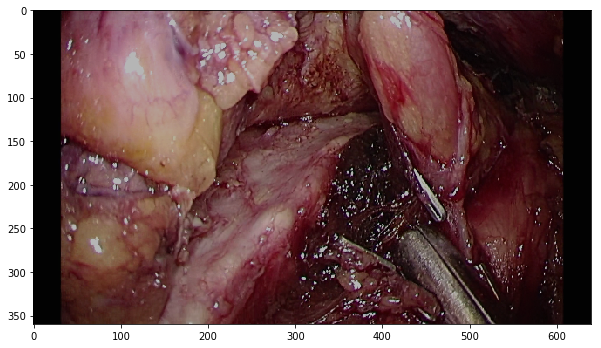

Data: 60
Ground Truth


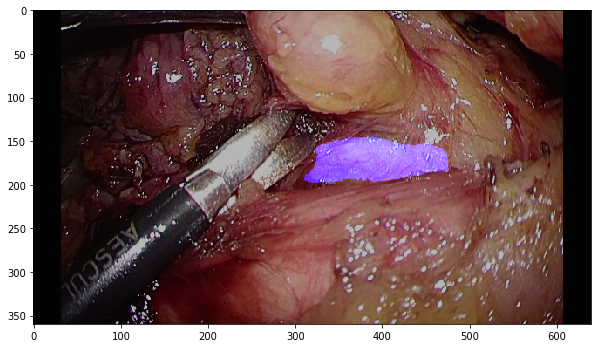



Predicted by DLV3P


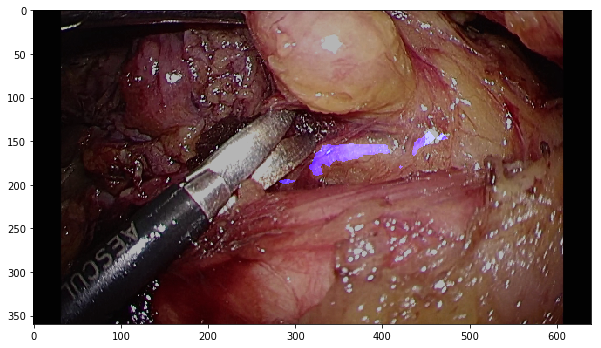



Predicted by Conventional Unet Structure


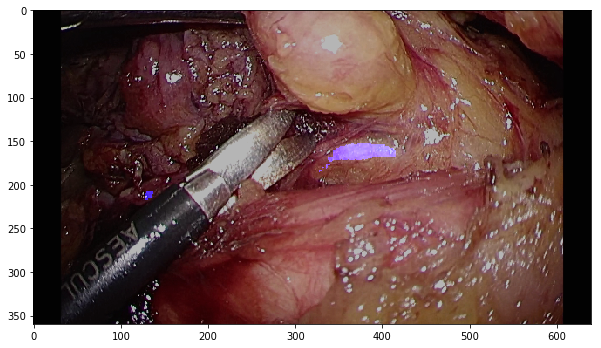

Data: 75
Ground Truth


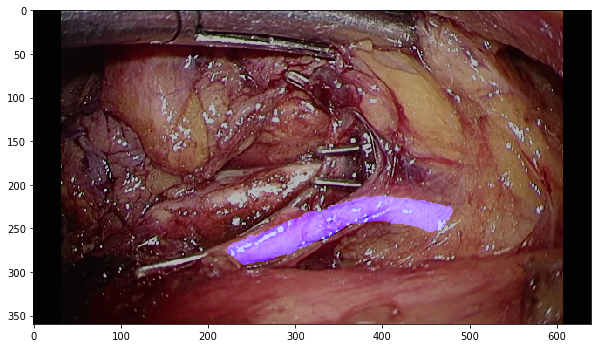



Predicted by DLV3P


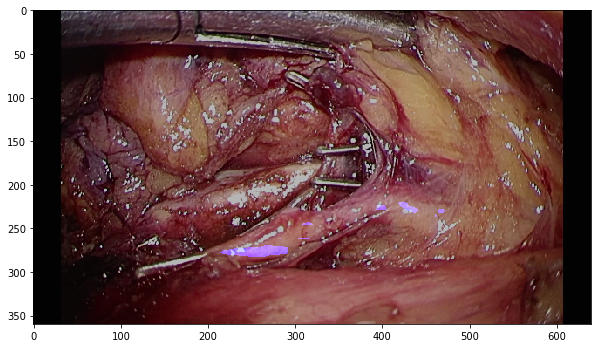



Predicted by Conventional Unet Structure


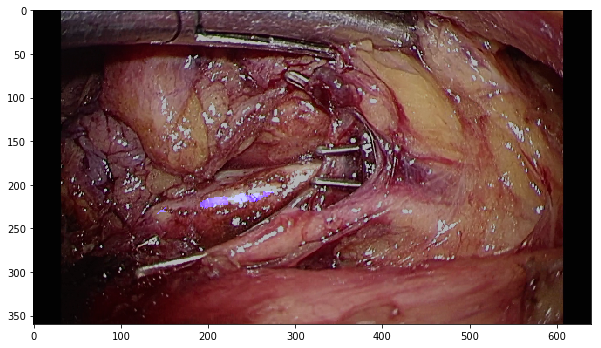

In [101]:
check_num = len(x)
y_pred = model.predict(x_test[:check_num])
y_pred2 = model2.predict(x_test[:check_num])



for i in range(check_num):
    if not (i%15==0):
        continue
    print('Data: '+str(i))
    print('Ground Truth')
    plt.figure(figsize=(10,10))
    plt.imshow((x_test[i]*255*x_std+x_mean)/255)
    blend_img_true = cv2.addWeighted((x_test[i]*255*x_std+x_mean).astype('uint8'), 0.7, np.concatenate([28*y[i, :].astype('uint8'),28*y[i, :].astype('uint8'),255*y[i, :].astype('uint8')], axis=2), 0.9, 2.2)
    plt.imshow(blend_img_true)
    plt.show()
    print('\n\nPredicted by DLV3P')
    plt.figure(figsize=(10,10))
    blend_img = cv2.addWeighted((x_test[i]*255*x_std+x_mean).astype('uint8'), 0.7, np.concatenate([28*y_pred[i, :].astype('uint8'),28*y_pred[i, :].astype('uint8'),255*y_pred[i, :].astype('uint8')], axis=2), 0.9, 2.2)
    plt.imshow(blend_img)
    plt.show()
    print('\n\nPredicted by Conventional Unet Structure')
    plt.figure(figsize=(10,10))
    blend_img2 = cv2.addWeighted((x_test[i]*255*x_std+x_mean).astype('uint8'), 0.7, np.concatenate([28*y_pred2[i, :].astype('uint8'),28*y_pred2[i, :].astype('uint8'),255*y_pred2[i, :].astype('uint8')], axis=2), 0.9, 2.2)
    plt.imshow(blend_img2)
    plt.show()
    
    

In [12]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
# with open('../result/try4_6_alldata_SGD/history.pickle', mode='rb') as f:
#     history = pickle.load(f)
# with open('../result/try4_7_alldata_additional_SGD/history.pickle', mode='rb') as f:
#     history2 = pickle.load(f)
# with open('../result/try4_8_alldata_additional_2_SGD/history.pickle', mode='rb') as f:
#     history3 = pickle.load(f)



with open('../result/try5_1_alldata_DLV3P/history.pickle', mode='rb') as f:
    history = pickle.load(f)
with open('../result/try5_2_alldata_additional_1_DLV3P/history.pickle', mode='rb') as f:
    history2 = pickle.load(f)    
    
with open('../result/try6_1_alldata_comparison_conventional/history.pickle', mode='rb') as f:
    history_conventional_1 = pickle.load(f)
with open('../result/try6_2_alldata_additional_1_comparison_conventional/history.pickle', mode='rb') as f:
    history_conventional_2 = pickle.load(f)
# with open('../result/try4_8_alldata_additional_2_SGD/history.pickle', mode='rb') as f:
#     history3 = pickle.load(f)
#with open('../result/try4_5_alldata_additional_3_SGD/history.pickle', mode='rb') as f:
#    history3 = pickle.load(f)

In [14]:
# loss_graph = np.hstack((history['loss'], history2['loss'], history3['loss']))
# val_loss_graph = np.hstack((history['val_loss'], history2['val_loss'], history3['val_loss']))


loss_graph = np.hstack((history['loss'], history2['loss']))
val_loss_graph = np.hstack((history['val_loss'], history2['val_loss']))

loss_conventional_graph = np.hstack((history_conventional_1['loss'], history_conventional_2['loss']))
val_loss_conventional_graph = np.hstack((history_conventional_1['val_loss'], history_conventional_2['val_loss']))


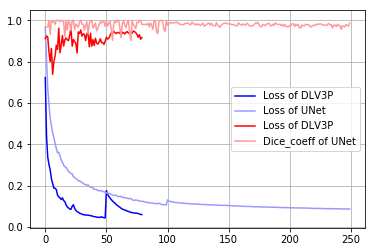

In [27]:
plt.plot(loss_graph, '#0000ff')
plt.plot(loss_conventional_graph, '#9999ff')

plt.plot(val_loss_graph, '#FF0000')
plt.plot(val_loss_conventional_graph, '#FF9999')
plt.grid()

plt.legend(['Loss of DLV3P','Loss of UNet','Loss of DLV3P','Dice_coeff of UNet'])
plt.show()

### Result

- 50 epochでLossが跳ねているのは、学習を複数回に分けその上重みの保存方法をBest-Onlyにしてしまったため
- DLV3Pがより優れた性能を発揮していると言える
- 一番Dice係数の大きい場所で比較するとDLV3PではDice係数0.23程度
- どちらのモデルも過学習している

### Descussion


- これ以上学習回数を増やしても性能の向上は見込めない
- DLV3Pの重要なハイパーパラメータにDilation Rateがあるので、これを調整したときどうなるか確認したい
- 興味として局所的な情報のみで達成可能なタスクとGlobalに特徴を抽出しないと達成困難なタスクを用意してDilation Rateに対する性能を比較したい
- やはり追加のデータが欲しい
- データさえあれば十分な性能が達成できる可能性が感じられた